<h1>Poles/Zeros/Gain from Look-Up Tables (Prototyping)</h1>

## Problem Statement

The IRIS metadata archiving process exhibits a strong preference for pole-zero ('zpk') representations of analog filters.  Because many MT instruments are characterized by  calibrations in the form of frequency sweeps the manufacturers calibrations are often provided in terms of tables of frequency, with amplitude and phase responses ('fap'). 

Thus we are faced with the problem of expressing a generic _fap_ instrument resposne in the _zpk_ format.

## Inverse Problem Setup

$\bf{d}$: The "data" in the the 'fap' table.  This is simply a set of $N$ ordered pairs, $\{(f_1, x_1), (f_2, x_2), ... (f_N, x_N)\}$ where $f_i \in \mathbb{R}^+$ and $x_i \in \mathbb{C}$

$\bf{G}$: The function relating the data and the model can take on several parameterizations.  One of the parameterizations is as a ratio of real valued polynomials:

$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} $

Where the Laplace variable _s_  = *j* $\omega$


$\bf{m}$:  Using the above parameterization $\bf{m}$ would be the set of $m + n + 2$ coefficients ${a_0, a_1, ...a_m, b_0, b_1, ... b_n}$ with $a_i, b_i \in \mathbb{R}$

<br>
<br>

The coefficients in the numerator and denominator polynomials in the Laplace domain representation of the filter are real. They typically correspond to values of circuit parameters resistance, capacitance, inductance, etc. in analog EE applications. This means that these polynomials factor completely over the complex plane and moreover, the roots are either real or occur in complex-conjugate pairs.
<br>
<br>

Factoring $h(s)$ on top and bottom yields the form:

$ \displaystyle h (s) = k  \frac{(s-z_1)(s-z_2)...(s-z_m) }{(s-p_1)(s-p_2)...(s-p_n)} $

There are well defined transformations between these representations and they are available through _scipy.signal.tf2zpk_ or _zpk2tf_.


### Recent Activity in PZ-fitting

Ben Murphy tried a variety of methods to solve this problem but invariably wound up encountering poles and zeros (roots) that did not obey the principle of complex-conjugate roots, and  sometimes poles on the right hand side of the plane, and or k values that were complex-valued.  The complex k values are particularl concerning because IRIS does not provide support for complex-valued k -- it is just one double-precision number.  

The reason for these issues deserves some analysis but at a high level seems to be due to parameterizations that ultimately wound up searching complex-valued spaces for soltuions.

Karl tried some variants on Ben's methods which involved some regularization functions that penalized non-conjugate root pairs, and imaginary parts of k, but these never matured so their value is questionable.

It seems like we should be able to use a numeric method to solve in the real valued form (even though the evaluation of the TF is Complex, the coefficients are real) and then extract the zpk afterwards ... no?



In [1]:
from mth5_test_data.util import MTH5_TEST_DATA_DIR
print(MTH5_TEST_DATA_DIR)

/home/kkappler/.cache/iris_mt/mth5_test_data/mth5_test_data


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from matplotlib.gridspec import GridSpec
#from plot_helpers import plot_response
from scipy import signal

from mt_metadata.timeseries.filters.plotting_helpers import plot_response
from iris_mt_scratch.sandbox.plot_helpers import plot_complex_response

from regularization_function_development import add_regularization_term 
from regularization_function_development import add_regularization_term2
from regularization_function_development import get_pz_regularization
from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LLSQ
from vectfit_python import vectfit
from zen import zen_response

%matplotlib inline


In [3]:
DEG2RAD = np.pi/180

## Load the data from data repo

In [4]:
calibration_data_dir = os.path.join(MTH5_TEST_DATA_DIR, 'calibration_files', '20210226', 'LEMI_Calibration', 'Lemi-039_N131BxByBz')
calibration_file_path = os.path.join(calibration_data_dir, 'Lemi-039_N131.cal' )
print(calibration_file_path)
df = pd.read_csv(calibration_file_path, skiprows=3, delimiter='\t')
column_labels = ['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y', 'amplitude_z', 'phase_z']
columns_map = dict(zip(df.columns, column_labels))
df = df.rename(columns=columns_map)
print(df.columns)


/home/kkappler/.cache/iris_mt/mth5_test_data/mth5_test_data/calibration_files/20210226/LEMI_Calibration/Lemi-039_N131BxByBz/Lemi-039_N131.cal
Index(['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y',
       'amplitude_z', 'phase_z'],
      dtype='object')


## Preliminary Response Curve

2021-05-07T15:47:45 [line 141] numexpr.utils._init_num_threads - INFO: NumExpr defaulting to 8 threads.


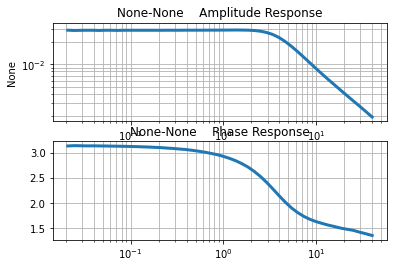

In [5]:
x_phase_radians = DEG2RAD*df['phase_x']
x_phasor = np.exp(1.J*x_phase_radians) #(np.cos( x_phase_radians)+ 1.j*np.sin(x_phase_radians))
x_complex_response = df['amplitude_x'] * x_phasor
X_COMPLEX_RESPONSE = x_complex_response #make it global for availabilty in objective functions
frequencies = df['frequency'].to_numpy()

plot_complex_response(df['frequency'], x_complex_response)

## Estimate the response amplitude in the pass band

In [6]:
nominal_passband_response_amplitude = df['amplitude_x'].iloc[10].mean()
print('nominal_passband_response_amplitude', nominal_passband_response_amplitude)

nominal_passband_response_amplitude 0.02847


## Express in units of deciBels and plot on semilog

In [7]:
amplitude_in_db = 20*np.log10(df['amplitude_x']/nominal_passband_response_amplitude)

Text(0.5, 1.0, 'Amplitude Response of Instrument in dB')

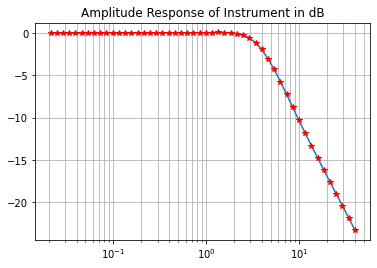

In [8]:
plt.semilogx(df['frequency'], amplitude_in_db)
plt.semilogx(df['frequency'], amplitude_in_db, 'r*')
plt.grid(which='both')
plt.title('Amplitude Response of Instrument in dB')


## Note that the decay is log-linear after about 5Hz

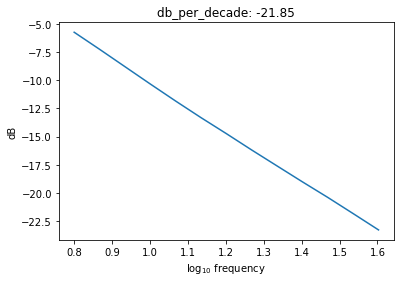

In [9]:
#The last 13 points are approximately a straight line on the log plot
n_asymptotic_log_linear = 13
frq_line = df['frequency'][-n_asymptotic_log_linear:]
ampl_line = df['amplitude_x'][-n_asymptotic_log_linear:]
db_line = amplitude_in_db[-n_asymptotic_log_linear:]
log_f = np.array(np.log10(frq_line))
log_a = np.array(np.log10(ampl_line))
db = np.array(db_line)
db_per_decade = (db[-1]-db[0]) / (log_f[-1]-log_f[0])

plt.plot(log_f, db_line)
plt.xlabel('log$_{10}$ frequency')
plt.ylabel('dB')
plt.title(f"db_per_decade: {db_per_decade:.2f}")
plt.show()

### looks like approximately -20dB/decade, which theoretically corresponds to a single pole.  We obtain a decent fit with one pole, but a better fit with 3poles and one zero.

If we want to optimize we need to add constraints however.  In particular, a regulariization that forces 1: complex poles to be conjugates, and the 'odd' poles to be pure real.  This means modifying the LLSQ process.

## Here is the solutions from Ben's ipynb using Linear Least Squares

[ 0.+0.j]
[-1032.30977561-43.56871821j   -19.41778864-14.74673119j
   -18.02197649+16.03155314j]


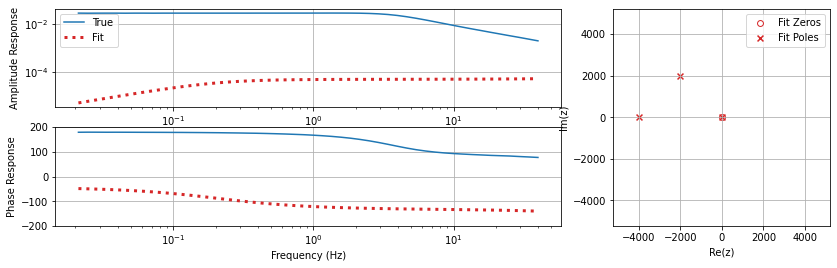

In [18]:
print(LEMI_LM_ZPK.zeros)
LEMI_LM_ZPK.zeros = [0+1.j*0]
print(LEMI_LM_ZPK.poles)# = [0+1.j*0]
LEMI_LM_ZPK.poles = [-1.28428+1.j*0, -1.99217e3 + 1.j*1.99221e3, -1.99217e3 +1.j*+ 1.j*1.99221e3]

#plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
#              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)

PARAMETERIZATION: 1 zeros, 3 poles
ZerosPolesGainContinuous(
array([-32.6930273+2.42939461j]),
array([-1032.30977561-43.56871821j,   -19.41778864-14.74673119j,
         -18.02197649+16.03155314j]),
(-526.39801470067096-20.959507362663881j),
dt: None
)


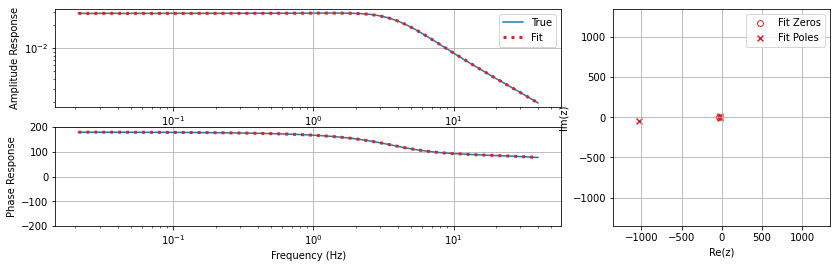

In [13]:
n_zeros = 2; n_poles = 3;
n_zeros = 1; n_poles = 3;
#n_zeros = 0; n_poles = 1;
#n_zeros = 2; n_poles = 3;
print("PARAMETERIZATION: {} zeros, {} poles".format(n_zeros, n_poles))
w_obs = 2*np.pi*frequencies
resp_obs =  x_complex_response#df['amplitude_x']
LEMI_LM_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(w_obs, 
                                                        resp_obs, 
                                                        n_zeros, n_poles, useSKiter=False, 
                                                         regularize=False)
print(LEMI_LM_ZPK)

plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)


In [ ]:
LEMI_LM_ZPK.gain = np.real(LEMI_LM_ZPK.gain)
print(LEMI_LM_ZPK.gain)
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)

Note that the fit here is "very good" (quantification needed in terms of % deviation from laboratory measurements and a residuals curve).  However to conjugate pairs are violated and k is complex values. 

**N.B. we want to achieve < 3% deviation from laboratory data** -JP

### Lets try a purely numerical approach using scipy optimize and some regularization that penalizes deviations from the fundamental theorem of algebra solutions

## Here we use pairs of real numbers to represent the poles and zeros

This method didn't work well, so skip it


In [ ]:
def make_zpk_from_model_vector(model_vector):
    """
    """
    zeros_real = model_vector[:2*N_ZEROS]
    poles_real = model_vector[2*N_ZEROS:2*N_ZEROS+2*N_POLES]
    k = model_vector[-1]
    zeros = np.zeros(N_ZEROS, dtype=np.complex128)
    for i_z in range(N_ZEROS):
        zeros[i_z] = np.complex(zeros_real[0+2*i_z], zeros_real[1+2*i_z])
    poles = np.zeros(N_POLES, dtype=np.complex128)
    for i_p in range(N_POLES):
        poles[i_p] = np.complex(poles_real[0+2*i_p], poles_real[1+2*i_p])
    return zeros, poles, k
        

In [ ]:
W = 2*np.pi*frequencies
S = 1.j*W
N_ZEROS = 1; N_POLES = 3
#N_ZEROS = 0; N_POLES = 1
z0 = np.zeros(2*N_ZEROS)#, dtype=np.complex128)
p0 = np.zeros(2*N_POLES)#, dtype=np.complex128)
k0 = 1.0
MODEL_VECTOR_0 = np.hstack((z0, p0, k0))
print(MODEL_VECTOR_0)
print(MODEL_VECTOR_0.dtype)
#Now we need a function that takes the MODEL_VECTOR as input and creates a lambda function for h(s)

def objective_function(model_vector, verbose=True):
    zeros, poles, k = make_zpk_from_model_vector(model_vector)
    #num, den = signal.zpk2tf(zeros, poles, k)
    w, h = signal.freqs_zpk(zeros, poles, k, worN=W)
    residual = X_COMPLEX_RESPONSE - h
    misfit = np.sqrt(np.mean(np.abs(residual**2)))
    misfit = add_regularization_term2(zeros, poles, k, misfit, aa=1e-5)
    if verbose:
        print(misfit)
    return misfit

#h = lambda:s
objective_function(MODEL_VECTOR_0)

In [ ]:
from scipy.optimize import minimize
method = 'nelder-mead'
#method = 'Powell'
#method = 'CG'
#method = 'Newton-CG'
res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })

In [ ]:
res.x

In [ ]:
zeros, poles, k = make_zpk_from_model_vector(res.x)
print('zeros', zeros)
print('poles', poles)
print('k', k)
tf = signal.zpk2tf(zeros, poles, k)

print(tf)
ZPK = signal.TransferFunction(tf[0], tf[1]).to_zpk()

In [ ]:
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=ZPK, w_values=w_obs)

## Something is wrong with the formulation here ... 

## Well, that sucks, how about fitting the tf directly


In [ ]:
W = 2*np.pi*frequencies

N_ZEROS = 0; N_POLES = 1
N_ZEROS = 1; N_POLES = 2#Very Good when seeded with 1
#N_ZEROS = 2; N_POLES = 3#Very Good when seeded with 3
#N_ZEROS = 3; N_POLES = 4#not so good
np.random.seed(1)
b0 = np.random.rand(N_ZEROS+1)
a0 = np.random.rand(N_POLES+1)

MODEL_VECTOR_0 = np.hstack((b0, a0))
#print('MODEL_VECTOR_0',MODEL_VECTOR_0)


def objective_function(model_vector, verbose=False):
    #unpack the model vector
    bb = model_vector[:N_ZEROS+1]
    aa = model_vector[N_ZEROS+1:]
    
    if verbose:
        print('numerator ', bb, N_ZEROS)
        print('denominator', aa, N_POLES)
    w, h = signal.freqs(bb, aa, worN=W)
    residual = X_COMPLEX_RESPONSE - h
    #print(residual)
    misfit = np.sqrt(np.mean(np.abs(residual**2)))
#    misfit = add_regularization_term(zeros, poles, k, misfit, aa=0.1)
    if verbose:
        print('misfit',misfit)
    return misfit

objective_function(MODEL_VECTOR_0, verbose=True)

In [ ]:
from scipy.optimize import minimize
method = 'nelder-mead'
method = 'Powell'
#method = 'CG'
#method = 'Newton-CG'
res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })

In [ ]:
res.x
bb = res.x[:N_ZEROS+1]
aa = res.x[N_ZEROS+1:]
zpk = signal.TransferFunction(bb, aa).to_zpk()
#zpk = signal.tf2zpk(bb, aa)
print(zpk)
#print(type(zpk))




In [ ]:
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=zpk, w_values=w_obs)

## So, where are we?

We have a numeric method that works "pretty  well" but could use some serious tuning
0. Need a RMS quantifier that tracks the goodness of fit
1. We have analytic expressions so lets get some Jacobians and Hessians and try some of the more classical approaches in scipy.minimize

2. Lets try a bunch of seed values for each optimization and explore the sum RMS misfits.  
3. Do (2) above for a collection of n_poles, n_zeros controls

4. Tidy up supporting codes and make some metrics/reports to use for these fits
5. Move on

## References
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.tf2zpk.html
-